# Phase 1 

### Preprocessing

In [2]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer

### Now load the pickle data into dataframes from the Output folder one directory above

In [3]:
def loadEverything():
    all_projects_bugreports = pd.read_pickle('Output/allBugReports.pickle')
    print("*** All Bug Reports are Loaded. ***")
    all_projects_source_codes = pd.read_pickle('Output/allSourceCodes.pickle')
    print("*** All Source Codes are Loaded. ***")
    return all_projects_bugreports, all_projects_source_codes

all_projects_bugreports, all_projects_source_codes = loadEverything()
display(all_projects_bugreports.iloc[0])
display(all_projects_source_codes.iloc[2])
display(all_projects_bugreports.iloc[0].name)
display(all_projects_source_codes.iloc[2].name)

*** All Bug Reports are Loaded. ***
*** All Source Codes are Loaded. ***


fix                  [org.apache.commons.collections.map.flat3map.j...
text                                                               NaN
fixdate                                            2006-07-18 22:02:11
summary              Flat3Map.Entry.setValue() overwrites other Ent...
description          Flat3Map&amp;apos;s Entry objects will overwri...
project                                                    COLLECTIONS
average_precision                                                    0
Name: 217, dtype: object

filename            \gitrepo\src\java\org\apache\commons\collectio...
unprocessed_code    /*\n *  Licensed to the Apache Software Founda...
project                                                   COLLECTIONS
Name: 2, dtype: object

'217'

2

In [4]:
# need to get the file names in the bug report an source code to be the same

# there is no index connection between bugreports index (.name) and the index of the source code
display(all_projects_bugreports.iloc[0].fix)
display(all_projects_source_codes.iloc[217].filename)


array(['org.apache.commons.collections.map.flat3map.java',
       'org.apache.commons.collections.map.testflat3map.java'],
      dtype='<U52')

'\\gitrepo\\src\\java\\org\\apache\\commons\\collections\\list\\transformedlist.java'

## Removing composite varaibles

In [5]:
import re
#remove next line characters:
def remove_new_lines(text):
#     return str(x).replace('\n', '').replace('*', '').replace('/', '').replace('\\','').replace('\t','')
    text = str(text)
    COMBINE_WHITE_SPACE = re.compile(r"(?a:\s+)")
    text = COMBINE_WHITE_SPACE.sub(' ', text)
    return text.replace('*', '').replace('/', '').replace('\\','')
    
# clean up the various white space and remove some *
def clean_new_lines_source_code(df):
    df.unprocessed_code = df.unprocessed_code.apply(remove_new_lines)
    return df

# clean up the description and summary, they will both be used for the query
def clean_new_lines_bug_report(df):
    df.summary = df.summary.apply(remove_new_lines)
    df['description'] = df['description'].astype('|S')
    df.description = df.description.apply(remove_new_lines)
    return df

# need to reformat the source code so it can be compared to the bug reports fix array
def format_sc_filename(x):
  
    x = x.split('apache')
    if len(x) != 2:
        x = x[0].split('springframework')
        if len(x) != 2:
            x = x[0].split('wildfly')
            if len(x) == 2:
                x = 'org.wildfly' + x[1]
        else:
             x = 'org.springframework' + x[1]
    else:
         x = 'org.apache' + x[1]
    if len(x) == 1:
        x = x[0]
   
    x = str(x).replace("\\",".")
    return x

# apply the fixes to the filename 
def clean_sc_filepath(df):
    df.filename = df.filename.apply(format_sc_filename)
    return df



In [6]:
#splitting composite words
def findCompositeWords(s):
    return ' '.join(re.findall('[A-Z][^A-Z]*', s))   


def clean_composite_source_code(df):
    df.unprocessed_code = df.unprocessed_code.apply(findCompositeWords)
    return df

def clean_composite_bug_report(df):
    df.summary = df.summary.apply(findCompositeWords)
    df.description = df.description.apply(findCompositeWords)
    return df


In [7]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# add the Java key words to the stop words
java_keywords = ["abstract", "assert**","assert", "boolean", "break", "byte", "case", "catch", "char", "const", "continue", "default", "do", "double", "else", "enum", "enum****" "extends", "final", "finally", "for", "goto","goto*", "if", "implements", "import", "instanceof", "int","interface", "long", "native", "new", "package", "private", "protected", "public", "return", "short", "static", "strictfp**","strictfp", "super", "switch", "synchornized", "this", "throw", "throws", "transient", "try", "void", "volatile", "while"]
java_operators = ["+", "-", "*", "/", "%", "+=", "-=", "*=", "/=", "++", "--", "==", "!=", "<", ">", "<=", ">=", ".", "[", "]", "(",")", "!", "~","instanceof", "<<", ">>", ">>>", "&", "^", "|", "&&", "||", "?", ":", "^=", "%=", "<<=", ">>=", ">>>=", "&="]
stop = java_keywords + java_operators
STOP_WORDS = ENGLISH_STOP_WORDS.union(stop)
# STOP_WORDS


### Text cleaning, remove stop words and Stemming

In [8]:
# remove the stem and stop words
# takes in an array of strings returns an array of strings
def stem_stop(text):
    stemmer = PorterStemmer()   #"english"
    text = text.split()
    text = [w for w in text if not w in STOP_WORDS]
    text = list(map(lambda x: stemmer.stem(x), text))
    text = ' '.join(text)
    text = text.strip()
    return text

# clean up the unprocessed code column
def clean_source_df(df):
    df = clean_new_lines_source_code(df)
    df = clean_composite_source_code(df)
    df = clean_sc_filepath(df)
    return df

# add the summary and description together and clean the data
def clean_combine_bug_df(df):
    df = clean_new_lines_bug_report(df)
    df = clean_composite_bug_report(df)
    df["query"] = df["summary"] + df["description"]
    return df


### Code for generating metrics on similarity scores

In [9]:
# rank all the similarity scores
def rank_sim_scores(scores):
    sim_scores = list()

#     print(len(scores)) # number of bug reports
    for score in scores:
        indicies = range(len(score))
#         print(len(score)) # number of source code files for this project
        scores_tuple = tuple(zip(score,indicies))
        sorted_tuple = sorted(scores_tuple, reverse = True)
#         display(sorted_tuple)
        sim_scores.append(sorted_tuple)
    
    return sim_scores

# look through the src data frame to find where the fix is. 
def get_fix_indexes(bug, src):
    fix_list = list()
    for fixes in bug["fix"]:
#         print(fixes)
        fix_sub=list()
        for fix in fixes:
#             print(fix)
            df = src[src["filename"].str.match(fix)]
            if(df.shape[0] != 0):
                fix_sub.append(df.index[0])
            else:
                fix_sub.append(-1)
#         print(fix_sub)
        fix_list.append(fix_sub)
#     print(fix_list)
    # this is a list of the indexes of the file where the fix was located
    return fix_list
        
        
def average_precision(bug,n=10):
#checks precision for the top n values. If n is too large then this score loses meaning
    ap_list = list()
    for index, row in bug.iterrows():
        countTrue = 0
        for i in range(len(row['ranked_sim'])):
            if i >= n:
                break
            # check if source file is actually where bug is located
            if(row['ranked_sim'][i][1] in row['fix_indexes']):
                countTrue+=1
        ap_list.append(countTrue/n)
    return ap_list


def reciprocal_rank(bug):
#reciprocal rank is 1/n, where n is the first position of a source file where the bug is located in the ranked_sim column
    rr_list = list()
    for index, row in bug.iterrows():
        rr = 0
        for i in range(len(row['ranked_sim'])):
            # check if source file is actually where bug is located
            if(row['ranked_sim'][i][1] in row['fix_indexes']):
                rr = 1/(i+1)
                break
        rr_list.append(rr)
    return rr_list


### Code for generating similarity score

In [10]:
from sklearn.metrics.pairwise import cosine_similarity


def calculate_similarity_eq7(src_files, src_vect, query, source_length_score, min_max_scaler):

    cosSim = cosine_similarity(query, src_vect)
    
    for i in range(len(cosSim)):
        cosSim[i] = cosSim[i] * source_length_score[i][0]
        print("cosSim", cosSim[i])
    return cosSim
    
def calculate_similarity(src_vect, query):
    cosSim = cosine_similarity(query, src_vect).flatten()
    return cosSim

# fit the vectorizer and transform data
def get_similarity(vect, src_files, src_vect, query_data, source_length_score, min_max_scaler):
    query = vect.transform(query_data)
    similarity = calculate_similarity(src_vect,query)  
    similarity_eq7 = calculate_similarity_eq7(src_files, src_vect, query, source_length_score, min_max_scaler)

    print("eq1:", len(similarity),"eq7:", len(similarity_eq7[0]))
    return similarity, similarity_eq7



### Get metrics into the data frames

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
# take in the source code df for a project and a signle query return scores
def generate_scores_list(source, query):
    scores_list = [] 
    scores_list_eq7 = []
    # get a list of strings from the data frames to be vectorized
    source['unprocessed_code'] = source['unprocessed_code'].map(stem_stop)
    query["query"] = query["query"].map(stem_stop)


     
    # fit a vectorizer to the data
    vect = TfidfVectorizer(min_df=1).fit(source['unprocessed_code'])
    src_vect = vect.transform(source['unprocessed_code'])
    
    source_lengths = []
    for src in src_vect:
        source_lengths.append(src.getnnz())
    source_lengths = np.array(source_lengths).reshape(-1,1)

    min_max_scaler = MinMaxScaler()
    normalized_source_length = min_max_scaler.fit_transform(source_lengths)
 
    source_length_score = 1 / (1 + np.exp(-1 * normalized_source_length))
    
    #get the similarity scores for the bug reports    
    #iterate through the query
    for q in query["query"]:
        similarity, similarity_eq7 = get_similarity(vect,source['unprocessed_code'], src_vect, [q], source_length_score, min_max_scaler)
        scores_list.append(similarity)
        scores_list_eq7.append(similarity_eq7)
        # some sort of data structure (dict) to collect the queries to add it to the dataframe later

    return scores_list, scores_list_eq7



def generate_all_scores():
    
    all_bugs = []
    all_src = []
    # iterate through the list of 12 projects
    i = 0;
    for proj in projects:
       
        # create dataframes for each project
        src_df = sc_grouped_df.get_group(proj)
        bug_df = bg_grouped_df.get_group(proj).copy()
        
        # generate the scores list
        scores, scores_eq7 = generate_scores_list(src_df, bug_df)

        #append scores list to the bug dataframe
        bug_df["sim_vect"] = scores # the only way that the matrix is related to the src code 
                                    # is through the index.
        bug_df["sim_eq7_vect"] = scores_eq7
        # Rank the source code files and know what file(s) the bug was in
        bug_df["ranked_sim"] = rank_sim_scores(scores)
        bug_df["ranked_eq7_sim"] = rank_sim_scores(scores_eq7)
   
        # get list of where the fixes rank
        bug_df["fix_indexes"] = get_fix_indexes(bug_df, src_df)

        #get location of the fix indexes within the ranked_sim
        
        # CALCULATE THE MAP AND MRR HERE WITH A FUNCTION AND ADD IT TO THE BUGS DATAFRAME
        bug_df["average_precision_1"] = average_precision(bug_df,1)
        bug_df["average_precision_3"] = average_precision(bug_df,3)
        bug_df["average_precision_5"] = average_precision(bug_df,5)
        bug_df["average_precision_10"] = average_precision(bug_df,10)

        bug_df["reciprocal_rank"] = reciprocal_rank(bug_df)
        
        # maintain a list of all the dataframes
        all_bugs.append(bug_df)
        all_src.append(src_df)
    # concatenate all the data frames in order    
    all_bug_df = pd.concat(all_bugs, ignore_index=True)
    all_src_df = pd.concat(all_src, ignore_index=True)
    return all_bug_df, all_src_df

In [12]:




# get clean versions of the dataframes
sc_df = clean_source_df(all_projects_source_codes)
br_df = clean_combine_bug_df(all_projects_bugreports)


# get a list of the projects 
print(sc_df.project.unique())
projects = sc_df.project.unique()

# group the data frames
# TODO ignore index here? Then maintain original index and concat the data frames
sc_grouped_df = sc_df.groupby(sc_df.project)
bg_grouped_df = br_df.groupby(br_df.project)

# example of getting a data frame for a single project
col_df = sc_grouped_df.get_group("COLLECTIONS")
display(col_df)




['COLLECTIONS' 'CONFIGURATION' 'IO' 'LANG' 'DATACMNS' 'DATAMONGO'
 'DATAREST' 'LDAP' 'SEC' 'SOCIALFB' 'SPR' 'ELY']


,filename,unprocessed_code,project
0,org.apache.commons.collections.arraystack.java,Licensed to the Apache Software Foundation ...,COLLECTIONS
1,org.apache.commons.collections.bag.java,Licensed to the Apache Software Foundation ...,COLLECTIONS
2,org.apache.commons.collections.bagutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS
3,org.apache.commons.collections.beanmap.java,Licensed to the Apache Software Foundation ...,COLLECTIONS
4,org.apache.commons.collections.bidimap.java,Licensed to the Apache Software Foundation ...,COLLECTIONS
...,...,...,...
471,org.apache.commons.collections.set.testtransfo...,Licensed to the Apache Software Foundation ...,COLLECTIONS
472,org.apache.commons.collections.set.testtypedse...,Licensed to the Apache Software Foundation ...,COLLECTIONS
473,org.apache.commons.collections.set.testtypedso...,Licensed to the Apache Software Foundation ...,COLLECTIONS
474,org.apache.commons.collections.set.testunmodif...,Licensed to the Apache Software Foundation ...,COLLECTIONS


In [13]:
bugs, sources = generate_all_scores()

<ipython-input-12-a857f32bb790>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['unprocessed_code'] = source['unprocessed_code'].map(stem_stop)


476
cosSim [0.03219175 0.0493213  0.00393503 0.07682254 0.14024302 0.01869513
 0.00445183 0.02235725 0.05303989 0.03131984 0.00724267 0.00855516
 0.00539476 0.00990083 0.01916144 0.06286141 0.01535227 0.03888448
 0.06905249 0.22109254 0.09201217 0.00530251 0.10576461 0.01548729
 0.01161228 0.02450557 0.13820146 0.12725784 0.00623445 0.02984066
 0.17374145 0.02676779 0.07800386 0.01812359 0.09364491 0.15827485
 0.14203577 0.1494722  0.09525505 0.08129903 0.00787238 0.09942515
 0.04906386 0.04414814 0.014072   0.0188147  0.12864177 0.16285148
 0.00560239 0.00505945 0.15954769 0.10975504 0.0163167  0.08421669
 0.11585004 0.00428065 0.03023128 0.03164535 0.03846821 0.02252713
 0.00726912 0.02094035 0.12370266 0.00480836 0.04085506 0.01475327
 0.0058255  0.02666545 0.00293805 0.0235602  0.00444641 0.04398216
 0.00461605 0.00440958 0.03662482 0.03555138 0.10420896 0.22473367
 0.06135714 0.06416455 0.08836663 0.12362591 0.09073114 0.12038865
 0.10700369 0.09754251 0.0067441  0.01537316 0.0100

 0.01439316 0.00699985]
eq1: 476 eq7: 476
cosSim [4.37727052e-03 3.74249027e-03 1.05301510e-03 7.97599124e-02
 2.28037650e-01 1.62235427e-03 1.52288631e-03 5.28824089e-03
 1.10205242e-01 5.60244624e-03 2.45259612e-03 2.49354699e-03
 1.35953390e-03 4.02923898e-03 2.15797479e-02 4.23907384e-02
 9.18763994e-03 1.09336390e-02 6.86119671e-02 2.27524469e-01
 6.04272391e-02 1.61599014e-03 1.61007729e-01 0.00000000e+00
 5.32745929e-03 8.51988553e-03 2.21357034e-01 2.36129603e-01
 1.74630581e-03 3.85295170e-02 1.99704236e-01 1.91026975e-02
 1.19466342e-01 3.19372093e-03 1.67562385e-01 1.28818162e-01
 2.34953263e-01 2.02008656e-01 1.73006469e-01 1.51146626e-01
 3.51408681e-03 2.38749228e-01 9.12634415e-02 1.69802502e-02
 7.23530898e-03 6.03393669e-04 2.28306427e-01 1.45428675e-01
 0.00000000e+00 0.00000000e+00 1.60613507e-01 2.95800871e-03
 8.73633799e-03 1.55193078e-01 1.48223441e-01 2.21651039e-03
 6.76803254e-03 3.75508563e-02 9.46656787e-02 1.61063842e-03
 1.62622330e-02 1.35985311e-03 9.165

 0.00621098 0.005666  ]
eq1: 476 eq7: 476
cosSim [0.01856494 0.05784751 0.00672556 0.01224275 0.01686995 0.00660547
 0.07215829 0.01872081 0.01083098 0.05416967 0.0045138  0.00524196
 0.00845146 0.02298149 0.01532339 0.05944936 0.00496776 0.01634109
 0.03448056 0.00716916 0.01425118 0.02637693 0.04717237 0.02864022
 0.0126864  0.0298545  0.03434381 0.0306961  0.00279841 0.05103586
 0.00468403 0.01591187 0.00834871 0.03436915 0.03218775 0.03128091
 0.01003698 0.04760456 0.03056916 0.03016346 0.0125496  0.00489717
 0.00963801 0.04902693 0.01547543 0.02310041 0.02520713 0.01155998
 0.0147034  0.01327846 0.01972959 0.01495238 0.00873683 0.02829781
 0.01735201 0.00804291 0.02041021 0.01804459 0.03473631 0.01515403
 0.01948088 0.00900184 0.03518307 0.00604454 0.02505088 0.00390662
 0.00311701 0.0042033  0.00401431 0.01024847 0.00938521 0.02267823
 0.0056262  0.00537455 0.03080659 0.02990369 0.01141831 0.03402682
 0.00413945 0.00467594 0.00895341 0.01317392 0.00925875 0.01163597
 0.00940626 0

 0.01262665 0.04300112]
eq1: 476 eq7: 476
cosSim [3.23967060e-02 3.58304537e-02 4.46745945e-03 2.22035644e-02
 5.89637008e-03 2.80492830e-02 3.88001648e-03 2.06652666e-02
 3.97991372e-03 6.95616736e-02 5.08923685e-03 5.17421158e-03
 4.12458243e-03 4.33236803e-03 4.99034798e-03 4.31871651e-02
 1.40149608e-02 7.98471309e-02 4.59637998e-02 1.25175952e-02
 2.19030071e-02 4.51811772e-02 5.10016133e-02 7.64490037e-03
 6.32520231e-03 1.61036648e-01 2.27386289e-02 2.39536084e-02
 1.89762621e-03 1.41936211e-03 1.71711900e-02 7.70062438e-02
 3.00635965e-03 1.86968552e-01 1.85827771e-02 2.66147217e-02
 1.15973028e-02 2.96976071e-02 1.95705208e-02 4.16919156e-02
 3.52677374e-02 4.98576686e-02 4.54478114e-02 7.13261738e-03
 6.44525558e-03 5.50033238e-03 2.78513134e-02 2.47592146e-02
 0.00000000e+00 6.80161964e-02 6.90404059e-02 1.30971520e-01
 3.98103228e-02 1.65476436e-02 2.53107775e-02 6.45093890e-03
 1.00884086e-02 1.12294835e-02 1.42856284e-02 2.19443191e-02
 1.70054941e-02 2.29223824e-02 3.046

id
217    [(0.4656718955142169, 222), (0.447279509685931...
214    [(0.10345136646680671, 3), (0.0880717932156749...
222    [(0.38644080002864695, 288), (0.37509355439192...
261    [(0.5591516607470604, 305), (0.503968358691063...
264    [(0.6582236412487737, 298), (0.643831204240897...
                             ...                        
577    [(0.12069235153633603, 109), (0.10860615800701...
580    [(0.23762779658622352, 137), (0.22792879438408...
583    [(0.0725756081794044, 60), (0.0442830912391032...
586    [(0.33840731012035485, 427), (0.32327573122239...
597    [(0.2173144095633128, 303), (0.194166721215988...
Name: ranked_sim, Length: 92, dtype: object

id
217    [([0.03219175459669851, 0.0493213000230787, 0....
214    [([0.007361614985021504, 0.015615661140801174,...
222    [([0.026677125420932958, 0.09112455013448502, ...
261    [([0.02051725961344751, 0.02533321583366596, 6...
264    [([0.00907724222195171, 0.009244505682413548, ...
                             ...                        
577    [([0.014542835182197431, 0.035295805074658286,...
580    [([0.028459494726220738, 0.06193984965635404, ...
583    [([0.0102962850227362, 0.014014897253093198, 0...
586    [([0.012154053329600335, 0.02718859614289278, ...
597    [([0.003697036592798685, 0.008341418430165263,...
Name: ranked_eq7_sim, Length: 92, dtype: object

,fix,text,fixdate,summary,description,project,average_precision,query,sim_vect,sim_eq7_vect,ranked_sim,ranked_eq7_sim,fix_indexes
id,,,,,,,,,,,,,
217,[org.apache.commons.collections.map.flat3map.j...,NaN,2006-07-18 22:02:11,Flat3 Map. Entry.set Value() overwrites other ...,Flat3 Map&amp;apos;s Entry objects will overw...,COLLECTIONS,0.0,flat3 map. entry.set value() overwrit entri va...,"[0.058548134080555064, 0.08970216513375899, 0....","[[0.03219175459669851, 0.0493213000230787, 0.0...","[(0.4656718955142169, 222), (0.447279509685931...","[([0.03219175459669851, 0.0493213000230787, 0....","[233, 436]"
214,[org.apache.commons.collections.testextendedpr...,NaN,2006-07-18 22:44:33,Extended Properties - field include should be ...,"The field ""include"" in Extended Properties is...",COLLECTIONS,0.0,extend properti field includ non-stat privatet...,"[0.013388795565578315, 0.028400683146419893, 0...","[[0.007361614985021504, 0.015615661140801174, ...","[(0.10345136646680671, 3), (0.0880717932156749...","[([0.007361614985021504, 0.015615661140801174,...","[292, 22]"
222,[org.apache.commons.collections.testlistutils....,NaN,2006-08-18 19:01:22,Collection Utils remove All is actually retain...,"The remove All( Collection collection, Collec...",COLLECTIONS,0.0,collect util remov all actual retain allth rem...,"[0.04851850840676917, 0.16573102168998424, 0.0...","[[0.026677125420932958, 0.09112455013448502, 0...","[(0.38644080002864695, 288), (0.37509355439192...","[([0.026677125420932958, 0.09112455013448502, ...","[303, 288, 15]"
261,[org.apache.commons.collections.map.flat3map.j...,NaN,2007-08-20 14:11:54,Flat3 Map.remove() does not return the correct...,Flat3 Map m = new Flat3 Map();n m.put( new I...,COLLECTIONS,0.0,flat3 map.remove() doe correct valu size 3flat...,"[0.03731537102786185, 0.046074298711050336, 0....","[[0.02051725961344751, 0.02533321583366596, 6....","[(0.5591516607470604, 305), (0.503968358691063...","[([0.02051725961344751, 0.02533321583366596, 6...","[233, 436]"
264,[org.apache.commons.collections.fasttreemap.java],NaN,2007-08-31 09:39:59,Fast Tree Map forgets the comparator,In line 359 and 582 of the current 3.2 release...,COLLECTIONS,0.0,fast tree map forget comparatorin line 359 582...,"[0.016509059582201484, 0.016813266781609673, 0...","[[0.00907724222195171, 0.009244505682413548, 0...","[(0.6582236412487737, 298), (0.643831204240897...","[([0.00907724222195171, 0.009244505682413548, ...",[27]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,[org.apache.commons.collections4.trie.patricia...,NaN,2015-09-28 09:45:19,Patricia Trie bugs when only a few bits change,"I have a bug report for you, for the class Ab...",COLLECTIONS,0.0,"patricia trie bug bit changei bug report you, ...","[0.0264495015828069, 0.06419356614392692, 0.00...","[[0.014542835182197431, 0.035295805074658286, ...","[(0.12069235153633603, 109), (0.10860615800701...","[([0.014542835182197431, 0.035295805074658286,...",[-1]
580,[org.apache.commons.collections4.multimap.mult...,NaN,2015-11-21 10:02:58,Arbitrary remote code execution with Invoker ...,With Invoker Transformer serializable collect...,COLLECTIONS,0.0,arbitrari remot code execut invok transformerw...,"[0.05176015827563829, 0.11265190941103775, 0.0...","[[0.028459494726220738, 0.06193984965635404, 0...","[(0.23762779658622352, 137), (0.22792879438408...","[([0.028459494726220738, 0.06193984965635404, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
583,[org.apache.commons.collections4.multimap.mult...,NaN,2015-12-14 07:47:22,"J A V A serialization vulnerability "" C V E-20...",The vulnerability we are talking about is know...,COLLECTIONS,0.0,"J A V A serial vulner "" C V e-2015-4852"" commo...","[0.018726170213306553, 0.025489324635428728, 0...","[[0.0102962850227362, 0.014014897253093198, 0....","[(0.0725756081794044, 60), (0.0442830912391032...","[([0.0102962850227362, 0.014014897253093198, 0...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


In [140]:
print(bugs.ranked_eq7_sim)

0     [([0.03219175459669851, 0.0493213000230787, 0....
1     [([0.007361614985021504, 0.015615661140801174,...
2     [([0.026677125420932958, 0.09112455013448502, ...
3     [([0.02051725961344751, 0.02533321583366596, 6...
4     [([0.00907724222195171, 0.009244505682413548, ...
                            ...                        
87    [([0.014542835182197431, 0.035295805074658286,...
88    [([0.028459494726220738, 0.06193984965635404, ...
89    [([0.0102962850227362, 0.014014897253093198, 0...
90    [([0.012154053329600335, 0.02718859614289278, ...
91    [([0.003697036592798685, 0.008341418430165263,...
Name: ranked_eq7_sim, Length: 92, dtype: object


## Calculate and graph MRR and MAP

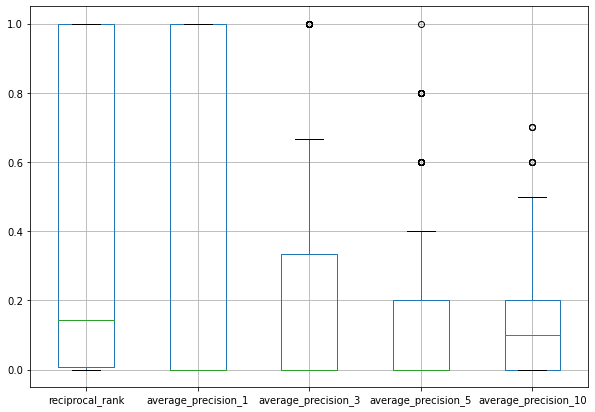

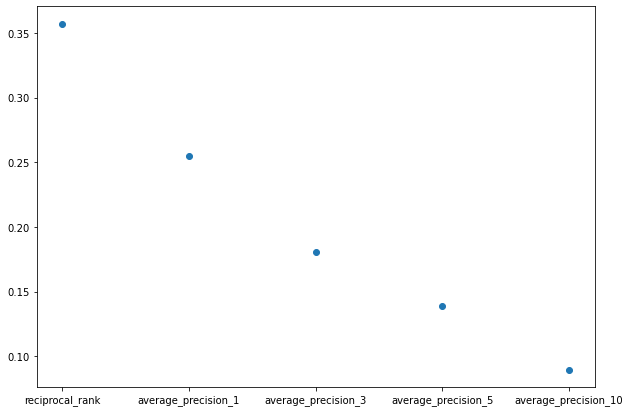

In [22]:
import matplotlib.pyplot as plt
def generate_graphs(bugs):
    # Im not too sure this boxplot is actually useful, at least not for reciprocal_rank and avearge_precision_1
    important_cols = ["reciprocal_rank","average_precision_1","average_precision_3","average_precision_5","average_precision_10"]
    boxplot = bugs.boxplot(column=important_cols,figsize=(10,7))
    mean_list = list()
    for col in important_cols:
        mean_list.append(bugs[col].mean())
    fig, ax = plt.subplots(figsize=(10,7))
    ax.scatter(important_cols,mean_list)
generate_graphs(bugs)

In [33]:
def performanceTable(bugs):
    data = []
    important_cols = ["reciprocal_rank","average_precision_1","average_precision_3","average_precision_5","average_precision_10"]
    for proj in projects:
        bug_df = bugs.groupby(bugs.project).get_group(proj).copy()
        perf_list = list()
        
        perf_list.append(bug_df['reciprocal_rank'].mean())

        perf_list.append(bug_df['average_precision_10'].mean())
        
        perf_list.append(len(bug_df[(bug_df['average_precision_1']!=0)]))
        perf_list.append(100 * len(bug_df[(bug_df['average_precision_1']!=0)])/(len(bug_df)))

        perf_list.append(len(bug_df[(bug_df['average_precision_3']!=0)]))
        perf_list.append(100 * len(bug_df[(bug_df['average_precision_3']!=0)])/(len(bug_df)))

        perf_list.append(len(bug_df[(bug_df['average_precision_5']!=0)]))
        perf_list.append(100 * len(bug_df[(bug_df['average_precision_5']!=0)])/(len(bug_df)))

        perf_list.append(len(bug_df[(bug_df['average_precision_10']!=0)]))
        perf_list.append(100 * len(bug_df[(bug_df['average_precision_10']!=0)])/(len(bug_df)))
        
        perf_list.append(len(bug_df))

        data.append(perf_list)
    df = pd.DataFrame(data,columns=["MRR","MAP (j=10)","Top 1 (Count)","Top 1 (%)","Top 3 (Count)","Top 3 (%)","Top 5 (Count)","Top 5 (%)","Top 10 (Count)","Top 10 (%)", "Total Count"])
    df['PROJECT'] = projects
    df = df.set_index(['PROJECT'])
    return df

performance_df = performanceTable(bugs)
performance_df

,MRR,MAP (j=10),Top 1 (Count),Top 1 (%),Top 3 (Count),Top 3 (%),Top 5 (Count),Top 5 (%),Top 10 (Count),Top 10 (%),Total Count
PROJECT,,,,,,,,,,,
COLLECTIONS,0.424600,0.101087,32,34.782609,45,48.913043,46,50.000000,48,52.173913,92
CONFIGURATION,0.472454,0.121805,48,36.090226,66,49.624060,84,63.157895,99,74.436090,133
IO,0.536720,0.105495,42,46.153846,54,59.340659,60,65.934066,62,68.131868,91
LANG,0.503349,0.120276,82,37.788018,132,60.829493,146,67.281106,152,70.046083,217
DATACMNS,0.443838,0.128481,51,32.278481,79,50.000000,97,61.392405,108,68.354430,158
DATAMONGO,0.302186,0.081181,51,18.819188,93,34.317343,112,41.328413,143,52.767528,271
DATAREST,0.400030,0.108333,37,28.030303,61,46.212121,69,52.272727,81,61.363636,132
LDAP,0.415503,0.116981,14,26.415094,27,50.943396,34,64.150943,36,67.924528,53
SEC,0.266030,0.063401,97,17.929760,166,30.683919,190,35.120148,237,43.807763,541


In [29]:
def findBugRanks(bug_vectors, source_codes):
    
    similarity_scores = []
    rank_indexs = []
    
    for project, vect, fixes in zip(bug_vectors['project'],bug_vectors['sim_vect'],bug_vectors['fix']): 
        
        code = sc_grouped_df.get_group(project)
        code = code['filename'].to_numpy()  ## find all code files pertaining to the bug reports project 
        
        z = [code for _,code in sorted(zip(vect,code),reverse=True)] ## sort the list of projects based on the similarity scores vector
        sorted_array = np.sort(vect)[::-1]
            
        for fix in fixes:
            try:
                index = z.index(fix)
                score = sorted_array[index]
                similarity_scores.append(score)
                rank_indexs.append(index)
                
                

            except:
                similarity_scores.append(fix)
                rank_indexs.append(-1)
                
    tup = zip(similarity_scores,rank_indexs) # zip the similarity scores along with the rank 
    
    return tup


tup = findBugRanks(bugs, sc_grouped_df)
# tuple(tup)

((0.4472795096859311, 1),
 (0.2913655231050407, 25),
 (0.03209980879562304, 16),
 (0.0880717932156749, 1),
 (0.31912456699257075, 4),
 (0.38644080002864695, 0),
 (0.28046076214130816, 8),
 (0.21328436467544076, 29),
 (0.5039683586910633, 1),
 (0.6438312042408976, 1),
 (0.423608812618834, 1),
 (0.5026370609304508, 0),
 (0.21673040369631835, 16),
 (0.43031369493789906, 1),
 (0.4909623398612745, 0),
 (0.2512620370028016, 14),
 (0.4730434626385859, 1),
 (0.486343809828954, 0),
 (0.13743009617270954, 51),
 (0.36345491909775834, 91),
 (0.40301763571397675, 1),
 (0.501993096040347, 0),
 (0.3028765649566887, 7),
 ('org.apache.commons.collections.splitmap.abstractiterablegetmapdecorator.java',
  -1),
 ('org.apache.commons.collections.splitmap.testtransformedmap.java', -1),
 (0.14718196728468272, 10),
 (0.23501428756066586, 1),
 (0.17707827762462128, 5),
 (0.29015004202166644, 21),
 (0.34800929761560623, 2),
 (0.4398117899012724, 0),
 (0.2478632221663548, 7),
 (0.32635182109160366, 2),
 (0.35617

## TODO list
- Generate graphs and report on the findings

In [30]:
src = sc_grouped_df.get_group("COLLECTIONS")
bug = bg_grouped_df.get_group("COLLECTIONS")
count = 0
fix_list = list()
for fixes in bug["fix"]:
    print(fixes)
    fix_sub=list()
    for fix in fixes:
        print(fix)
        df = src[src["filename"].str.match(fix)]
        display(df)
        try:
            print(df.index[0])
            fix_sub.append(df.index[0])
        except:
            count += 1
            fix_sub.append(-1)
    print(fix_sub)
    fix_list.append(fix_sub)
print(fix_list)
print(count) # 328 missing
# this is a list of the indexes of the file where the fix was located


['org.apache.commons.collections.map.flat3map.java'
 'org.apache.commons.collections.map.testflat3map.java']
org.apache.commons.collections.map.flat3map.java


,filename,unprocessed_code,project
233,org.apache.commons.collections.map.flat3map.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


233
org.apache.commons.collections.map.testflat3map.java


,filename,unprocessed_code,project
436,org.apache.commons.collections.map.testflat3ma...,Licensed to the Apache Software Foundation ...,COLLECTIONS


436
[233, 436]
['org.apache.commons.collections.testextendedproperties.java'
 'org.apache.commons.collections.extendedproperties.java']
org.apache.commons.collections.testextendedproperties.java


,filename,unprocessed_code,project
292,org.apache.commons.collections.testextendedpro...,Licensed to the Apache Software Foundation ...,COLLECTIONS


292
org.apache.commons.collections.extendedproperties.java


,filename,unprocessed_code,project
22,org.apache.commons.collections.extendedpropert...,Licensed to the Apache Software Foundation ...,COLLECTIONS


22
[292, 22]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.map.flat3map.java'
 'org.apache.commons.collections.map.testflat3map.java']
org.apache.commons.collections.map.flat3map.java


,filename,unprocessed_code,project
233,org.apache.commons.collections.map.flat3map.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


233
org.apache.commons.collections.map.testflat3map.java


,filename,unprocessed_code,project
436,org.apache.commons.collections.map.testflat3ma...,Licensed to the Apache Software Foundation ...,COLLECTIONS


436
[233, 436]
['org.apache.commons.collections.fasttreemap.java']
org.apache.commons.collections.fasttreemap.java


,filename,unprocessed_code,project
27,org.apache.commons.collections.fasttreemap.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


27
[27]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.map.abstractlinkedmap.java']
org.apache.commons.collections.map.abstractlinkedmap.java


,filename,unprocessed_code,project
223,org.apache.commons.collections.map.abstractlin...,Licensed to the Apache Software Foundation ...,COLLECTIONS


223
[223]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.splitmap.abstractiterablegetmapdecorator.java'
 'org.apache.commons.collections.splitmap.testtransformedmap.java']
org.apache.commons.collections.splitmap.abstractiterablegetmapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections.splitmap.testtransformedmap.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.iterators.testfilterlistiterator.java'
 'org.apache.commons.collections.iterators.filterlistiterator.java']
org.apache.commons.collections.iterators.testfilterlistiterator.java


,filename,unprocessed_code,project
387,org.apache.commons.collections.iterators.testf...,Licensed to the Apache Software Foundation ...,COLLECTIONS


387
org.apache.commons.collections.iterators.filterlistiterator.java


,filename,unprocessed_code,project
178,org.apache.commons.collections.iterators.filte...,Licensed to the Apache Software Foundation ...,COLLECTIONS


178
[387, 178]
['org.apache.commons.collections.iterators.collatingiterator.java'
 'org.apache.commons.collections.iterators.testcollatingiterator.java'
 'org.apache.commons.collections.comparators.comparablecomparator.java']
org.apache.commons.collections.iterators.collatingiterator.java


,filename,unprocessed_code,project
169,org.apache.commons.collections.iterators.colla...,Licensed to the Apache Software Foundation ...,COLLECTIONS


169
org.apache.commons.collections.iterators.testcollatingiterator.java


,filename,unprocessed_code,project
385,org.apache.commons.collections.iterators.testc...,Licensed to the Apache Software Foundation ...,COLLECTIONS


385
org.apache.commons.collections.comparators.comparablecomparator.java


,filename,unprocessed_code,project
108,org.apache.commons.collections.comparators.com...,Licensed to the Apache Software Foundation ...,COLLECTIONS


108
[169, 385, 108]
['org.apache.commons.collections.map.identitymap.java'
 'org.apache.commons.collections.map.abstracthashedmap.java'
 'org.apache.commons.collections.map.caseinsensitivemap.java'
 'org.apache.commons.collections.map.abstractlinkedmap.java'
 'org.apache.commons.collections.map.testhashedmap.java'
 'org.apache.commons.collections.map.testidentitymap.java'
 'org.apache.commons.collections.map.hashedmap.java'
 'org.apache.commons.collections.map.testcaseinsensitivemap.java'
 'org.apache.commons.collections.map.testlinkedmap.java'
 'org.apache.commons.collections.map.linkedmap.java']
org.apache.commons.collections.map.identitymap.java


,filename,unprocessed_code,project
235,org.apache.commons.collections.map.identitymap...,Licensed to the Apache Software Foundation ...,COLLECTIONS


235
org.apache.commons.collections.map.abstracthashedmap.java


,filename,unprocessed_code,project
221,org.apache.commons.collections.map.abstracthas...,Licensed to the Apache Software Foundation ...,COLLECTIONS


221
org.apache.commons.collections.map.caseinsensitivemap.java


,filename,unprocessed_code,project
228,org.apache.commons.collections.map.caseinsensi...,Licensed to the Apache Software Foundation ...,COLLECTIONS


228
org.apache.commons.collections.map.abstractlinkedmap.java


,filename,unprocessed_code,project
223,org.apache.commons.collections.map.abstractlin...,Licensed to the Apache Software Foundation ...,COLLECTIONS


223
org.apache.commons.collections.map.testhashedmap.java


,filename,unprocessed_code,project
437,org.apache.commons.collections.map.testhashedm...,Licensed to the Apache Software Foundation ...,COLLECTIONS


437
org.apache.commons.collections.map.testidentitymap.java


,filename,unprocessed_code,project
438,org.apache.commons.collections.map.testidentit...,Licensed to the Apache Software Foundation ...,COLLECTIONS


438
org.apache.commons.collections.map.hashedmap.java


,filename,unprocessed_code,project
234,org.apache.commons.collections.map.hashedmap.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


234
org.apache.commons.collections.map.testcaseinsensitivemap.java


,filename,unprocessed_code,project
431,org.apache.commons.collections.map.testcaseins...,Licensed to the Apache Software Foundation ...,COLLECTIONS


431
org.apache.commons.collections.map.testlinkedmap.java


,filename,unprocessed_code,project
441,org.apache.commons.collections.map.testlinkedm...,Licensed to the Apache Software Foundation ...,COLLECTIONS


441
org.apache.commons.collections.map.linkedmap.java


,filename,unprocessed_code,project
238,org.apache.commons.collections.map.linkedmap.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


238
[235, 221, 228, 223, 437, 438, 234, 431, 441, 238]
['org.apache.commons.collections.maputils.java']
org.apache.commons.collections.maputils.java


,filename,unprocessed_code,project
36,org.apache.commons.collections.maputils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


36
[36]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.functors.prototypefactory.java'
 'org.apache.commons.collections.factoryutils.java']
org.apache.commons.collections.functors.prototypefactory.java


,filename,unprocessed_code,project
152,org.apache.commons.collections.functors.protot...,Licensed to the Apache Software Foundation ...,COLLECTIONS


152
org.apache.commons.collections.factoryutils.java


,filename,unprocessed_code,project
24,org.apache.commons.collections.factoryutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


24
[152, 24]
['org.apache.commons.collections.transformerutils.java']
org.apache.commons.collections.transformerutils.java


,filename,unprocessed_code,project
57,org.apache.commons.collections.transformerutil...,Licensed to the Apache Software Foundation ...,COLLECTIONS


57
[57]
['org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[15]
['org.apache.commons.collections.maputils.java']
org.apache.commons.collections.maputils.java


,filename,unprocessed_code,project
36,org.apache.commons.collections.maputils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


36
[36]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.listutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.listutils.java


,filename,unprocessed_code,project
33,org.apache.commons.collections.listutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


33
[303, 33]
['org.apache.commons.collections.set.listorderedset.java']
org.apache.commons.collections.set.listorderedset.java


,filename,unprocessed_code,project
261,org.apache.commons.collections.set.listordered...,Licensed to the Apache Software Foundation ...,COLLECTIONS


261
[261]
['org.apache.commons.collections.set.listorderedset.java']
org.apache.commons.collections.set.listorderedset.java


,filename,unprocessed_code,project
261,org.apache.commons.collections.set.listordered...,Licensed to the Apache Software Foundation ...,COLLECTIONS


261
[261]
['org.apache.commons.collections.bidimap.abstractdualbidimap.java']
org.apache.commons.collections.bidimap.abstractdualbidimap.java


,filename,unprocessed_code,project
77,org.apache.commons.collections.bidimap.abstrac...,Licensed to the Apache Software Foundation ...,COLLECTIONS


77
[77]
['org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[15]
['org.apache.commons.collections.list.abstractlinkedlist.java']
org.apache.commons.collections.list.abstractlinkedlist.java


,filename,unprocessed_code,project
206,org.apache.commons.collections.list.abstractli...,Licensed to the Apache Software Foundation ...,COLLECTIONS


206
[206]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.map.abstractlinkedmap.java']
org.apache.commons.collections.map.abstractlinkedmap.java


,filename,unprocessed_code,project
223,org.apache.commons.collections.map.abstractlin...,Licensed to the Apache Software Foundation ...,COLLECTIONS


223
[223]
['org.apache.commons.collections.map.abstractlinkedmap.java']
org.apache.commons.collections.map.abstractlinkedmap.java


,filename,unprocessed_code,project
223,org.apache.commons.collections.map.abstractlin...,Licensed to the Apache Software Foundation ...,COLLECTIONS


223
[223]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.listutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.listutils.java


,filename,unprocessed_code,project
33,org.apache.commons.collections.listutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


33
[303, 33]
['org.apache.commons.collections.list.setuniquelist.java'
 'org.apache.commons.collections.list.testsetuniquelist.java']
org.apache.commons.collections.list.setuniquelist.java


,filename,unprocessed_code,project
215,org.apache.commons.collections.list.setuniquel...,Licensed to the Apache Software Foundation ...,COLLECTIONS


215
org.apache.commons.collections.list.testsetuniquelist.java


,filename,unprocessed_code,project
420,org.apache.commons.collections.list.testsetuni...,Licensed to the Apache Software Foundation ...,COLLECTIONS


420
[215, 420]
['org.apache.commons.collections.listutils.java']
org.apache.commons.collections.listutils.java


,filename,unprocessed_code,project
33,org.apache.commons.collections.listutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


33
[33]
['org.apache.commons.collections.map.testcaseinsensitivemap.java'
 'org.apache.commons.collections.map.caseinsensitivemap.java']
org.apache.commons.collections.map.testcaseinsensitivemap.java


,filename,unprocessed_code,project
431,org.apache.commons.collections.map.testcaseins...,Licensed to the Apache Software Foundation ...,COLLECTIONS


431
org.apache.commons.collections.map.caseinsensitivemap.java


,filename,unprocessed_code,project
228,org.apache.commons.collections.map.caseinsensi...,Licensed to the Apache Software Foundation ...,COLLECTIONS


228
[431, 228]
['org.apache.commons.collections.testextendedproperties.java'
 'org.apache.commons.collections.extendedproperties.java']
org.apache.commons.collections.testextendedproperties.java


,filename,unprocessed_code,project
292,org.apache.commons.collections.testextendedpro...,Licensed to the Apache Software Foundation ...,COLLECTIONS


292
org.apache.commons.collections.extendedproperties.java


,filename,unprocessed_code,project
22,org.apache.commons.collections.extendedpropert...,Licensed to the Apache Software Foundation ...,COLLECTIONS


22
[292, 22]
['org.apache.commons.collections.keyvalue.multikey.java'
 'org.apache.commons.collections.keyvalue.testmultikey.java']
org.apache.commons.collections.keyvalue.multikey.java


,filename,unprocessed_code,project
203,org.apache.commons.collections.keyvalue.multik...,Licensed to the Apache Software Foundation ...,COLLECTIONS


203
org.apache.commons.collections.keyvalue.testmultikey.java


,filename,unprocessed_code,project
409,org.apache.commons.collections.keyvalue.testmu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


409
[203, 409]
['org.apache.commons.collections.list.setuniquelist.java'
 'org.apache.commons.collections.list.testsetuniquelist.java']
org.apache.commons.collections.list.setuniquelist.java


,filename,unprocessed_code,project
215,org.apache.commons.collections.list.setuniquel...,Licensed to the Apache Software Foundation ...,COLLECTIONS


215
org.apache.commons.collections.list.testsetuniquelist.java


,filename,unprocessed_code,project
420,org.apache.commons.collections.list.testsetuni...,Licensed to the Apache Software Foundation ...,COLLECTIONS


420
[215, 420]
['org.apache.commons.collections.map.multivaluemap.java'
 'org.apache.commons.collections.map.testmultivaluemap.java']
org.apache.commons.collections.map.multivaluemap.java


,filename,unprocessed_code,project
242,org.apache.commons.collections.map.multivaluem...,Licensed to the Apache Software Foundation ...,COLLECTIONS


242
org.apache.commons.collections.map.testmultivaluemap.java


,filename,unprocessed_code,project
446,org.apache.commons.collections.map.testmultiva...,Licensed to the Apache Software Foundation ...,COLLECTIONS


446
[242, 446]
['org.apache.commons.collections.bag.testtreebag.java'
 'org.apache.commons.collections.testtreebag.java'
 'org.apache.commons.collections.bag.treebag.java'
 'org.apache.commons.collections.treebag.java']
org.apache.commons.collections.bag.testtreebag.java


,filename,unprocessed_code,project
325,org.apache.commons.collections.bag.testtreebag...,Licensed to the Apache Software Foundation ...,COLLECTIONS


325
org.apache.commons.collections.testtreebag.java


,filename,unprocessed_code,project
313,org.apache.commons.collections.testtreebag.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


313
org.apache.commons.collections.bag.treebag.java


,filename,unprocessed_code,project
71,org.apache.commons.collections.bag.treebag.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


71
org.apache.commons.collections.treebag.java


,filename,unprocessed_code,project
58,org.apache.commons.collections.treebag.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


58
[325, 313, 71, 58]
['org.apache.commons.collections.map.lrumap.java']
org.apache.commons.collections.map.lrumap.java


,filename,unprocessed_code,project
240,org.apache.commons.collections.map.lrumap.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


240
[240]
['org.apache.commons.collections.list.setuniquelist.java'
 'org.apache.commons.collections.list.testsetuniquelist.java']
org.apache.commons.collections.list.setuniquelist.java


,filename,unprocessed_code,project
215,org.apache.commons.collections.list.setuniquel...,Licensed to the Apache Software Foundation ...,COLLECTIONS


215
org.apache.commons.collections.list.testsetuniquelist.java


,filename,unprocessed_code,project
420,org.apache.commons.collections.list.testsetuni...,Licensed to the Apache Software Foundation ...,COLLECTIONS


420
[215, 420]
['org.apache.commons.collections.testextendedproperties.java'
 'org.apache.commons.collections.extendedproperties.java']
org.apache.commons.collections.testextendedproperties.java


,filename,unprocessed_code,project
292,org.apache.commons.collections.testextendedpro...,Licensed to the Apache Software Foundation ...,COLLECTIONS


292
org.apache.commons.collections.extendedproperties.java


,filename,unprocessed_code,project
22,org.apache.commons.collections.extendedpropert...,Licensed to the Apache Software Foundation ...,COLLECTIONS


22
[292, 22]
['org.apache.commons.collections.maputils.java']
org.apache.commons.collections.maputils.java


,filename,unprocessed_code,project
36,org.apache.commons.collections.maputils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


36
[36]
['org.apache.commons.collections.map.testcompositemap.java'
 'org.apache.commons.collections.set.testcompositeset.java'
 'org.apache.commons.collections.collection.compositecollection.java'
 'org.apache.commons.collections.map.compositemap.java'
 'org.apache.commons.collections.collection.testcompositecollection.java']
org.apache.commons.collections.map.testcompositemap.java


,filename,unprocessed_code,project
432,org.apache.commons.collections.map.testcomposi...,Licensed to the Apache Software Foundation ...,COLLECTIONS


432
org.apache.commons.collections.set.testcompositeset.java


,filename,unprocessed_code,project
461,org.apache.commons.collections.set.testcomposi...,Licensed to the Apache Software Foundation ...,COLLECTIONS


461
org.apache.commons.collections.collection.compositecollection.java


,filename,unprocessed_code,project
100,org.apache.commons.collections.collection.comp...,Licensed to the Apache Software Foundation ...,COLLECTIONS


100
org.apache.commons.collections.map.compositemap.java


,filename,unprocessed_code,project
229,org.apache.commons.collections.map.compositema...,Licensed to the Apache Software Foundation ...,COLLECTIONS


229
org.apache.commons.collections.collection.testcompositecollection.java


,filename,unprocessed_code,project
354,org.apache.commons.collections.collection.test...,Licensed to the Apache Software Foundation ...,COLLECTIONS


354
[432, 461, 100, 229, 354]
['org.apache.commons.collections.buffer.testunboundedfifobuffer.java'
 'org.apache.commons.collections.buffer.unboundedfifobuffer.java'
 'org.apache.commons.collections.abstracttestobject.java']
org.apache.commons.collections.buffer.testunboundedfifobuffer.java


,filename,unprocessed_code,project
350,org.apache.commons.collections.buffer.testunbo...,Licensed to the Apache Software Foundation ...,COLLECTIONS


350
org.apache.commons.collections.buffer.unboundedfifobuffer.java


,filename,unprocessed_code,project
96,org.apache.commons.collections.buffer.unbounde...,Licensed to the Apache Software Foundation ...,COLLECTIONS


96
org.apache.commons.collections.abstracttestobject.java


,filename,unprocessed_code,project
273,org.apache.commons.collections.abstracttestobj...,Licensed to the Apache Software Foundation ...,COLLECTIONS


273
[350, 96, 273]
['org.apache.commons.collections.map.multivaluemap.java'
 'org.apache.commons.collections.map.testmultivaluemap.java']
org.apache.commons.collections.map.multivaluemap.java


,filename,unprocessed_code,project
242,org.apache.commons.collections.map.multivaluem...,Licensed to the Apache Software Foundation ...,COLLECTIONS


242
org.apache.commons.collections.map.testmultivaluemap.java


,filename,unprocessed_code,project
446,org.apache.commons.collections.map.testmultiva...,Licensed to the Apache Software Foundation ...,COLLECTIONS


446
[242, 446]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections.comparators.transformingcomparator.java'
 'org.apache.commons.collections.comparators.transformingcomparatortest.java'
 'org.apache.commons.collections.comparatorutils.java']
org.apache.commons.collections.comparators.transformingcomparator.java


,filename,unprocessed_code,project
113,org.apache.commons.collections.comparators.tra...,Licensed to the Apache Software Foundation ...,COLLECTIONS


113
org.apache.commons.collections.comparators.transformingcomparatortest.java


,filename,unprocessed_code,project


org.apache.commons.collections.comparatorutils.java


,filename,unprocessed_code,project
16,org.apache.commons.collections.comparatorutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


16
[113, -1, 16]
['org.apache.commons.collections.set.compositesettest.java'
 'org.apache.commons.collections.collection.compositecollectiontest.java'
 'org.apache.commons.collections.set.emptysetmutator.java'
 'org.apache.commons.collections.collection.compositecollection.java'
 'org.apache.commons.collections.set.compositeset.java']
org.apache.commons.collections.set.compositesettest.java


,filename,unprocessed_code,project


org.apache.commons.collections.collection.compositecollectiontest.java


,filename,unprocessed_code,project


org.apache.commons.collections.set.emptysetmutator.java


,filename,unprocessed_code,project


org.apache.commons.collections.collection.compositecollection.java


,filename,unprocessed_code,project
100,org.apache.commons.collections.collection.comp...,Licensed to the Apache Software Foundation ...,COLLECTIONS


100
org.apache.commons.collections.set.compositeset.java


,filename,unprocessed_code,project
260,org.apache.commons.collections.set.compositese...,Licensed to the Apache Software Foundation ...,COLLECTIONS


260
[-1, -1, -1, 100, 260]
['org.apache.commons.collections4.list.setuniquelisttest.java'
 'org.apache.commons.collections4.list.setuniquelist.java'
 'org.apache.commons.collections.list.setuniquelisttest.java'
 'org.apache.commons.collections.list.setuniquelist.java']
org.apache.commons.collections4.list.setuniquelisttest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.setuniquelist.java


,filename,unprocessed_code,project


org.apache.commons.collections.list.setuniquelisttest.java


,filename,unprocessed_code,project


org.apache.commons.collections.list.setuniquelist.java


,filename,unprocessed_code,project
215,org.apache.commons.collections.list.setuniquel...,Licensed to the Apache Software Foundation ...,COLLECTIONS


215
[-1, -1, -1, 215]
['org.apache.commons.collections4.map.multivaluemaptest.java'
 'org.apache.commons.collections4.map.multivaluemap.java']
org.apache.commons.collections4.map.multivaluemaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.multivaluemap.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections.bag.testtransformedbag.java'
 'org.apache.commons.collections.setutils.java'
 'org.apache.commons.collections.set.testtransformedset.java'
 'org.apache.commons.collections.bufferutils.java'
 'org.apache.commons.collections.bag.transformedsortedbag.java'
 'org.apache.commons.collections.bag.transformedbag.java'
 'org.apache.commons.collections.list.transformedlist.java'
 'org.apache.commons.collections.listutils.java'
 'org.apache.commons.collections.buffer.testtransformedbuffer.java'
 'org.apache.commons.collections.collection.transformedcollection.java'
 'org.apache.commons.collections.set.testtransformedsortedset.java'
 'org.apache.commons.collections.set.transformedsortedset.java'
 'org.apache.commons.collections.buffer.transformedbuffer.java'
 'org.apache.commons.collections.list.testtransformedlist.java'
 'org.apache.commons.collections.collectionutils.java'
 'org.apache.commons.collections.bagutils.java'
 'org.apache.commons.collections.s

,filename,unprocessed_code,project
323,org.apache.commons.collections.bag.testtransfo...,Licensed to the Apache Software Foundation ...,COLLECTIONS


323
org.apache.commons.collections.setutils.java


,filename,unprocessed_code,project
51,org.apache.commons.collections.setutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


51
org.apache.commons.collections.set.testtransformedset.java


,filename,unprocessed_code,project
470,org.apache.commons.collections.set.testtransfo...,Licensed to the Apache Software Foundation ...,COLLECTIONS


470
org.apache.commons.collections.bufferutils.java


,filename,unprocessed_code,project
12,org.apache.commons.collections.bufferutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


12
org.apache.commons.collections.bag.transformedsortedbag.java


,filename,unprocessed_code,project
70,org.apache.commons.collections.bag.transformed...,Licensed to the Apache Software Foundation ...,COLLECTIONS


70
org.apache.commons.collections.bag.transformedbag.java


,filename,unprocessed_code,project
69,org.apache.commons.collections.bag.transformed...,Licensed to the Apache Software Foundation ...,COLLECTIONS


69
org.apache.commons.collections.list.transformedlist.java


,filename,unprocessed_code,project
217,org.apache.commons.collections.list.transforme...,Licensed to the Apache Software Foundation ...,COLLECTIONS


217
org.apache.commons.collections.listutils.java


,filename,unprocessed_code,project
33,org.apache.commons.collections.listutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


33
org.apache.commons.collections.buffer.testtransformedbuffer.java


,filename,unprocessed_code,project
349,org.apache.commons.collections.buffer.testtran...,Licensed to the Apache Software Foundation ...,COLLECTIONS


349
org.apache.commons.collections.collection.transformedcollection.java


,filename,unprocessed_code,project
103,org.apache.commons.collections.collection.tran...,Licensed to the Apache Software Foundation ...,COLLECTIONS


103
org.apache.commons.collections.set.testtransformedsortedset.java


,filename,unprocessed_code,project
471,org.apache.commons.collections.set.testtransfo...,Licensed to the Apache Software Foundation ...,COLLECTIONS


471
org.apache.commons.collections.set.transformedsortedset.java


,filename,unprocessed_code,project
268,org.apache.commons.collections.set.transformed...,Licensed to the Apache Software Foundation ...,COLLECTIONS


268
org.apache.commons.collections.buffer.transformedbuffer.java


,filename,unprocessed_code,project
94,org.apache.commons.collections.buffer.transfor...,Licensed to the Apache Software Foundation ...,COLLECTIONS


94
org.apache.commons.collections.list.testtransformedlist.java


,filename,unprocessed_code,project
422,org.apache.commons.collections.list.testtransf...,Licensed to the Apache Software Foundation ...,COLLECTIONS


422
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
org.apache.commons.collections.bagutils.java


,filename,unprocessed_code,project
2,org.apache.commons.collections.bagutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


2
org.apache.commons.collections.set.transformedset.java


,filename,unprocessed_code,project
267,org.apache.commons.collections.set.transformed...,Licensed to the Apache Software Foundation ...,COLLECTIONS


267
org.apache.commons.collections.collection.testtransformedcollection.java


,filename,unprocessed_code,project
357,org.apache.commons.collections.collection.test...,Licensed to the Apache Software Foundation ...,COLLECTIONS


357
org.apache.commons.collections.bag.testtransformedsortedbag.java


,filename,unprocessed_code,project
324,org.apache.commons.collections.bag.testtransfo...,Licensed to the Apache Software Foundation ...,COLLECTIONS


324
[323, 51, 470, 12, 70, 69, 217, 33, 349, 103, 471, 268, 94, 422, 15, 2, 267, 357, 324]
['org.apache.commons.collections4.map.flat3map.java']
org.apache.commons.collections4.map.flat3map.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.functors.switchtransformer.java'
 'org.apache.commons.collections4.functors.switchclosure.java'
 'org.apache.commons.collections4.functors.chainedtransformer.java'
 'org.apache.commons.collections4.functors.chainedclosure.java'
 'org.apache.commons.collections4.functors.instantiatetransformer.java'
 'org.apache.commons.collections4.functors.invokertransformer.java']
org.apache.commons.collections4.functors.switchtransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.switchclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.chainedtransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.chainedclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.instantiatetransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.invokertransformer.java


,filename,unprocessed_code,project


[-1, -1, -1, -1, -1, -1]
['org.apache.commons.collections4.bag.abstractmapbag.java']
org.apache.commons.collections4.bag.abstractmapbag.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.map.transformedmap.java'
 'org.apache.commons.collections4.splitmaputilstest.java'
 'org.apache.commons.collections4.splitmap.transformedmaptest.java'
 'org.apache.commons.collections4.splitmap.transformedmap.java']
org.apache.commons.collections4.map.transformedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.splitmaputilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.splitmap.transformedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.splitmap.transformedmap.java


,filename,unprocessed_code,project


[-1, -1, -1, -1]
['org.apache.commons.collections4.map.listorderedmap.java'
 'org.apache.commons.collections4.map.listorderedmaptest.java']
org.apache.commons.collections4.map.listorderedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.listorderedmaptest.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.map.passiveexpiringmap.java'
 'org.apache.commons.collections4.map.passiveexpiringmaptest.java']
org.apache.commons.collections4.map.passiveexpiringmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.passiveexpiringmaptest.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections.testlistutils.java'
 'org.apache.commons.collections.testcollectionutils.java'
 'org.apache.commons.collections.collectionutils.java']
org.apache.commons.collections.testlistutils.java


,filename,unprocessed_code,project
303,org.apache.commons.collections.testlistutils.java,Licensed to the Apache Software Foundation ...,COLLECTIONS


303
org.apache.commons.collections.testcollectionutils.java


,filename,unprocessed_code,project
288,org.apache.commons.collections.testcollectionu...,Licensed to the Apache Software Foundation ...,COLLECTIONS


288
org.apache.commons.collections.collectionutils.java


,filename,unprocessed_code,project
15,org.apache.commons.collections.collectionutils...,Licensed to the Apache Software Foundation ...,COLLECTIONS


15
[303, 288, 15]
['org.apache.commons.collections4.collectionutilstest.java'
 'org.apache.commons.collections4.collectionutils.java']
org.apache.commons.collections4.collectionutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collectionutils.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.collectionutilstest.java'
 'org.apache.commons.collections4.collectionutils.java']
org.apache.commons.collections4.collectionutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collectionutils.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.trie.unmodifiabletrietest.java'
 'org.apache.commons.collections4.trie.unmodifiabletrie.java'
 'org.apache.commons.collections4.trieutilstest.java']
org.apache.commons.collections4.trie.unmodifiabletrietest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.trie.unmodifiabletrie.java


,filename,unprocessed_code,project


org.apache.commons.collections4.trieutilstest.java


,filename,unprocessed_code,project


[-1, -1, -1]
['org.apache.commons.collections4.collection.unmodifiableboundedcollection.java'
 'org.apache.commons.collections4.collection.unmodifiableboundedcollectiontest.java']
org.apache.commons.collections4.collection.unmodifiableboundedcollection.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collection.unmodifiableboundedcollectiontest.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.multimap.java'
 'org.apache.commons.collections4.map.multivaluemaptest.java'
 'org.apache.commons.collections4.map.multivaluemap.java']
org.apache.commons.collections4.multimap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.multivaluemaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.multivaluemap.java


,filename,unprocessed_code,project


[-1, -1, -1]
['org.apache.commons.collections4.map.multikeymaptest.java'
 'org.apache.commons.collections4.map.multikeymap.java']
org.apache.commons.collections4.map.multikeymaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.multikeymap.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.collectionutils.java']
org.apache.commons.collections4.collectionutils.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.comparatorutils.java']
org.apache.commons.collections4.comparatorutils.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.set.listorderedset.java'
 'org.apache.commons.collections4.set.listorderedsettest.java']
org.apache.commons.collections4.set.listorderedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.listorderedsettest.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.maputils.java']
org.apache.commons.collections4.maputils.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.collectionutils.java']
org.apache.commons.collections4.collectionutils.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.bag.collectionbag.java']
org.apache.commons.collections4.bag.collectionbag.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.maputils.java']
org.apache.commons.collections4.maputils.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.functors.chainedclosure.java'
 'org.apache.commons.collections4.functors.nonepredicate.java'
 'org.apache.commons.collections4.transformerutils.java'
 'org.apache.commons.collections4.functors.chainedtransformer.java'
 'org.apache.commons.collections4.predicateutils.java'
 'org.apache.commons.collections4.functors.allpredicate.java'
 'org.apache.commons.collections4.functors.onepredicate.java'
 'org.apache.commons.collections4.closureutils.java'
 'org.apache.commons.collections4.functors.functorutils.java'
 'org.apache.commons.collections4.functors.anypredicate.java']
org.apache.commons.collections4.functors.chainedclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.nonepredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.transformerutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.chainedtransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.predicateutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.allpredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.onepredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.closureutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.functorutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.anypredicate.java


,filename,unprocessed_code,project


[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
['org.apache.commons.collections4.trie.abstractpatriciatrie.java'
 'org.apache.commons.collections4.trie.patriciatrietest.java']
org.apache.commons.collections4.trie.abstractpatriciatrie.java


,filename,unprocessed_code,project


org.apache.commons.collections4.trie.patriciatrietest.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.collection.abstractcollectiondecorator.java'
 'org.apache.commons.collections4.comparators.fixedordercomparator.java'
 'org.apache.commons.collections4.comparators.transformingcomparator.java'
 'org.apache.commons.collections4.comparators.transformingcomparatortest.java']
org.apache.commons.collections4.collection.abstractcollectiondecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.comparators.fixedordercomparator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.comparators.transformingcomparator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.comparators.transformingcomparatortest.java


,filename,unprocessed_code,project


[-1, -1, -1, -1]
['org.apache.commons.collections4.collectionutils.java']
org.apache.commons.collections4.collectionutils.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.multimap.abstractmultivaluedmap.java'
 'org.apache.commons.collections4.list.transformedlist.java'
 'org.apache.commons.collections4.set.predicatedset.java'
 'org.apache.commons.collections4.list.abstractlistdecorator.java'
 'org.apache.commons.collections4.multimap.abstractmultivaluedmaptest.java'
 'org.apache.commons.collections4.set.abstractsetdecorator.java'
 'org.apache.commons.collections4.bag.abstractbagdecorator.java'
 'org.apache.commons.collections4.queue.abstractqueuedecorator.java'
 'org.apache.commons.collections4.bidimap.abstractdualbidimap.java'
 'org.apache.commons.collections4.bag.predicatedbag.java'
 'org.apache.commons.collections4.set.transformedset.java'
 'org.apache.commons.collections4.list.predicatedlist.java'
 'org.apache.commons.collections4.bag.synchronizedbag.java'
 'org.apache.commons.collections4.bag.transformedbag.java'
 'org.apache.commons.collections4.collection.abstractcollectiondecorator.java']
org.apache.commons

,filename,unprocessed_code,project


org.apache.commons.collections4.list.transformedlist.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.predicatedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.abstractlistdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractmultivaluedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.abstractsetdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.abstractbagdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.queue.abstractqueuedecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bidimap.abstractdualbidimap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.predicatedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.transformedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.predicatedlist.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.synchronizedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.transformedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collection.abstractcollectiondecorator.java


,filename,unprocessed_code,project


[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
['org.apache.commons.collections4.collectionutils.java']
org.apache.commons.collections4.collectionutils.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.set.listorderedset.java'
 'org.apache.commons.collections4.set.listorderedsettest.java'
 'org.apache.commons.collections.set.listorderedset.java'
 'org.apache.commons.collections.set.listorderedsettest.java']
org.apache.commons.collections4.set.listorderedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.listorderedsettest.java


,filename,unprocessed_code,project


org.apache.commons.collections.set.listorderedset.java


,filename,unprocessed_code,project
261,org.apache.commons.collections.set.listordered...,Licensed to the Apache Software Foundation ...,COLLECTIONS


261
org.apache.commons.collections.set.listorderedsettest.java


,filename,unprocessed_code,project


[-1, -1, 261, -1]
['org.apache.commons.collections4.list.setuniquelisttest.java'
 'org.apache.commons.collections4.list.setuniquelist.java'
 'org.apache.commons.collections.list.setuniquelisttest.java'
 'org.apache.commons.collections.list.setuniquelist.java']
org.apache.commons.collections4.list.setuniquelisttest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.setuniquelist.java


,filename,unprocessed_code,project


org.apache.commons.collections.list.setuniquelisttest.java


,filename,unprocessed_code,project


org.apache.commons.collections.list.setuniquelist.java


,filename,unprocessed_code,project
215,org.apache.commons.collections.list.setuniquel...,Licensed to the Apache Software Foundation ...,COLLECTIONS


215
[-1, -1, -1, 215]
['org.apache.commons.collections4.bag.treebagtest.java'
 'org.apache.commons.collections4.bag.treebag.java']
org.apache.commons.collections4.bag.treebagtest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.treebag.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.set.listorderedset.java']
org.apache.commons.collections4.set.listorderedset.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.iteratorutils.java'
 'org.apache.commons.collections4.iteratorutilstest.java']
org.apache.commons.collections4.iteratorutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iteratorutilstest.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.set.listorderedsettest.java'
 'org.apache.commons.collections4.functors.anypredicate.java'
 'org.apache.commons.collections4.trie.unmodifiabletrie.java'
 'org.apache.commons.collections4.splitmap.transformedsplitmap.java'
 'org.apache.commons.collections4.collection.unmodifiableboundedcollectiontest.java'
 'org.apache.commons.collections4.map.unmodifiablesortedmap.java'
 'org.apache.commons.collections4.collection.unmodifiablecollectiontest.java'
 'org.apache.commons.collections4.map.predicatedmap.java'
 'org.apache.commons.collections4.list.unmodifiablelist.java'
 'org.apache.commons.collections4.iterators.pushbackiterator.java'
 'org.apache.commons.collections4.functors.functorutils.java'
 'org.apache.commons.collections4.predicateutilstest.java'
 'org.apache.commons.collections4.splitmap.abstractiterablegetmapdecorator.java'
 'org.apache.commons.collections4.collectionutilstest.java'
 'org.apache.commons.collections4.transformerutilstest.ja

,filename,unprocessed_code,project


org.apache.commons.collections4.functors.anypredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.trie.unmodifiabletrie.java


,filename,unprocessed_code,project


org.apache.commons.collections4.splitmap.transformedsplitmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collection.unmodifiableboundedcollectiontest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.unmodifiablesortedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collection.unmodifiablecollectiontest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.predicatedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.unmodifiablelist.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.pushbackiterator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.functorutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.predicateutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.splitmap.abstractiterablegetmapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collectionutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.transformerutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collection.transformedcollection.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.abstractsortedbagdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.fixedsizelist.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.unmodifiablebagtest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.abstractorderedmapiteratordecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.allpredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bidimap.unmodifiablebidimap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multiset.abstractmultisetdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.fixedsizemap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.unmodifiableorderedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.abstractsetdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.passiveexpiringmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.transformedlist.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.predicatedsortedbagtest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.nonepredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.closureutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.maputilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.transformedpredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.unmodifiableset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.abstractbagdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractmultivaluedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.queue.abstractqueuedecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.transformedsortedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.trieutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.closuretransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.queue.predicatedqueue.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.unmodifiablesortedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.lazymap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.unmodifiablesortedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bidimap.unmodifiableorderedbidimap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.abstractuntypediteratordecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collection.abstractcollectiondecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.setutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.lazylist.java


,filename,unprocessed_code,project


org.apache.commons.collections4.trieutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.predicatedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.transformednavigableset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.switchclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.andpredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.abstractorderedmapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.predicatedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.unmodifiablelistiterator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.collectionbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bidimap.abstractsortedbidimapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.predicatedbagtest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.defaultedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.abstractiteratordecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.multikeymap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.abstractmapiteratordecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.factoryutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.queue.unmodifiablequeue.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.abstractcompositepredicatetest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.switchtransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.unmodifiablelistiteratortest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.chainedclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.unmodifiablesortedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.instantiatefactory.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.nodelistiteratortest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.abstractnavigablesetdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collection.unmodifiablecollection.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.unmodifiablenavigablesettest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.predicatedsortedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.transformedsortedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collection.unmodifiableboundedcollection.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bagutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.unmodifiableiterator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.closureutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.nullisexceptionpredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.keyvalue.abstractmapentrydecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collection.synchronizedcollection.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.notpredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.queueutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.splitmaputils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.abstractsortedsetdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.listorderedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.lazysortedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.transformedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.predicatedlist.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.unmodifiableorderedmapiterator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.transformerpredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collectionutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.growthlist.java


,filename,unprocessed_code,project


org.apache.commons.collections4.factoryutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.instanceofpredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.setuniquelist.java


,filename,unprocessed_code,project


org.apache.commons.collections4.transformerutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.nullisfalsepredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bidimap.unmodifiableorderedbidimaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.invokertransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.abstractserializablesetdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.predicatedsortedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.comparators.fixedordercomparator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.collectionsortedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.unmodifiablesettest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.reverselistiterator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bidimap.unmodifiablesortedbidimaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bidimap.unmodifiablebidimaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.chainedtransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.singletonmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.fixedsizesortedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.predicatedsortedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.maputils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.nodelistiterator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.listutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.mapbackedset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.transformedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.passiveexpiringmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.unmodifiablesortedsettest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bidimap.abstractorderedbidimapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.collection.predicatedcollection.java


,filename,unprocessed_code,project


org.apache.commons.collections4.queue.unmodifiablequeuetest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.unmodifiableorderedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.abstractmapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.boundediterator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.unmodifiablemap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.unmodifiableentryset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.setutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.queue.transformedqueue.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.listorderedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.unmodifiablemapiterator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.lazysortedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.unmodifiablesortedbagtest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bidimap.abstractbidimapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.listutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.onepredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.abstractlistiteratordecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.unmodifiableorderedmapiteratortest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.predicateutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.queueutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.transformedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.abstractsortedmapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.abstractinputcheckedmapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.unmodifiablelisttest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.abstractserializablelistdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.transformedsortedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.ifclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.nullistruepredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.predicatednavigableset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iteratorutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.unmodifiableiteratortest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.orpredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.trie.unmodifiabletrietest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.peekingiterator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.iterators.unmodifiablemapiteratortest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.whileclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.identitypredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.iftransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.synchronizedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.instantiatetransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.list.abstractlistdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.synchronizedsortedbag.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.unmodifiablemaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bagutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bidimap.unmodifiablesortedbidimap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.comparatorpredicate.java


,filename,unprocessed_code,project


org.apache.commons.collections4.set.unmodifiablenavigableset.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.factorytransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.bag.unmodifiablebag.java


,filename,unprocessed_code,project


[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
['org.apache.commons.collections4.keyvalue.multikeytest.java'
 'org.apache.commons.collections4.keyvalue.multikey.java']
org.apache.commons.collections4.keyvalue.multikeytest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.keyvalue.multikey.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.trie.patriciatrietest.java']
org.apache.commons.collections4.trie.patriciatrietest.java


,filename,unprocessed_code,project


[-1]
['org.apache.commons.collections4.multimap.multivaluedhashmap.java'
 'org.apache.commons.collections4.multimap.multivaluedhashmaptest.java'
 'org.apache.commons.collections4.multimap.transformedmultivaluedmaptest.java'
 'org.apache.commons.collections4.multimap.abstractmultivaluedmaptest.java'
 'org.apache.commons.collections4.multimap.abstractmultivaluedmapdecorator.java'
 'org.apache.commons.collections4.multimap.unmodifiablemultivaluedmaptest.java'
 'org.apache.commons.collections4.multimap.abstractsetvaluedmap.java'
 'org.apache.commons.collections4.multimap.abstractmultivaluedmap.java'
 'org.apache.commons.collections4.multimaputilstest.java'
 'org.apache.commons.collections4.multimap.transformedmultivaluedmap.java'
 'org.apache.commons.collections4.multimap.package-info.java'
 'org.apache.commons.collections4.multimap.abstractlistvaluedmap.java'
 'org.apache.commons.collections4.multimaputils.java'
 'org.apache.commons.collections4.transformerutils.java'
 'org.apache.commons

,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.multivaluedhashmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.transformedmultivaluedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractmultivaluedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractmultivaluedmapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.unmodifiablemultivaluedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractsetvaluedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractmultivaluedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimaputilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.transformedmultivaluedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.package-info.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractlistvaluedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimaputils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.transformerutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.closureutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.factoryutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.multivaluemaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.multivaluemap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.factoryutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.transformerutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.instantiatefactory.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.whileclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.clonetransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.forclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.invokertransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.prototypefactory.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.package-info.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.instantiatetransformer.java


,filename,unprocessed_code,project


[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
['org.apache.commons.collections4.multimap.multivaluedhashmap.java'
 'org.apache.commons.collections4.multimap.multivaluedhashmaptest.java'
 'org.apache.commons.collections4.multimap.transformedmultivaluedmaptest.java'
 'org.apache.commons.collections4.multimap.abstractmultivaluedmaptest.java'
 'org.apache.commons.collections4.multimap.abstractmultivaluedmapdecorator.java'
 'org.apache.commons.collections4.multimap.unmodifiablemultivaluedmaptest.java'
 'org.apache.commons.collections4.multimap.abstractsetvaluedmap.java'
 'org.apache.commons.collections4.multimap.abstractmultivaluedmap.java'
 'org.apache.commons.collections4.multimaputilstest.java'
 'org.apache.commons.collections4.multimap.transformedmultivaluedmap.java'
 'org.apache.commons.collections4.multimap.package-info.java'
 'org.apache.commons.collections4.multimap.abstractlistvaluedmap.java'
 'org.apache.commons.co

,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.multivaluedhashmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.transformedmultivaluedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractmultivaluedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractmultivaluedmapdecorator.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.unmodifiablemultivaluedmaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractsetvaluedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractmultivaluedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimaputilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.transformedmultivaluedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.package-info.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimap.abstractlistvaluedmap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.multimaputils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.transformerutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.closureutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.factoryutils.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.multivaluemaptest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.map.multivaluemap.java


,filename,unprocessed_code,project


org.apache.commons.collections4.factoryutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.transformerutilstest.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.instantiatefactory.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.whileclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.clonetransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.forclosure.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.invokertransformer.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.prototypefactory.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.package-info.java


,filename,unprocessed_code,project


org.apache.commons.collections4.functors.instantiatetransformer.java


,filename,unprocessed_code,project


[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
['org.apache.commons.collections4.trie.abstractpatriciatrie.java'
 'org.apache.commons.collections4.trie.patriciatrietest.java']
org.apache.commons.collections4.trie.abstractpatriciatrie.java


,filename,unprocessed_code,project


org.apache.commons.collections4.trie.patriciatrietest.java


,filename,unprocessed_code,project


[-1, -1]
['org.apache.commons.collections4.functors.catchandrethrowclosure.java']
org.apache.commons.collections4.functors.catchandrethrowclosure.java


,filename,unprocessed_code,project


[-1]
[[233, 436], [292, 22], [303, 288, 15], [233, 436], [27], [303, 288, 15], [303, 288, 15], [303, 288, 15], [223], [303, 288, 15], [-1, -1], [303, 288, 15], [387, 178], [169, 385, 108], [235, 221, 228, 223, 437, 438, 234, 431, 441, 238], [36], [303, 288, 15], [152, 24], [57], [15], [36], [303, 33], [261], [261], [77], [15], [206], [303, 288, 15], [303, 288, 15], [303, 288, 15], [223], [223], [303, 33], [215, 420], [33], [431, 228], [292, 22], [203, 409], [215, 420], [242, 446], [325, 313, 71, 58], [240], [215, 420], [292, 22], [36], [432, 461, 100, 229, 354], [350, 96, 273], [242, 446], [303, 288, 15], [113, -1, 16], [-1, -1, -1, 100, 260], [-1, -1, -1, 215], [-1, -1], [323, 51, 470, 12, 70, 69, 217, 33, 349, 103, 471, 268, 94, 422, 15, 2, 267, 357, 324], [-1], [-1, -1, -1, -1, -1, -1], [-1], [-1, -1, -1, -1], [-1, -1], [-1, -1], [303, 288, 15], [-1, -1], [-1, -1], [-1, -1, -1], [-1, -1], [-1, -1, -1], [-1, -1], [-1], [-1], [-1, -1], [-1], [-1], [-1], [-1], [-1, -1, -1, -1, -1, -1, 